# Fish Segmentation
> Performed on a large scale fish dataset

In [ ]:
# Obtaining Dataset
!pip install -q kaggle

from google.colab import files 
files.upload()


!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d crowww/a-large-scale-fish-dataset
!unzip a-large-scale-fish-dataset.zip -d a-large-scale-fish-dataset

Streaming output truncated to the last 5000 lines.
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: a-large-scale-fi

In [ ]:
# Import Required Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image

In [ ]:
# Constants 
NUM_WORKERS = 2
BATCH_SIZE = 32
TRAIN_TEST_SPLIT_PERC = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.0001
EPOCHS = 5
IMAGE_SIZE = (224,224)
TRANSFORMS = A.Compose([
                        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
                        ToTensor()
])
LOSS_FUNCTION = nn.BCEWithLogitsLoss()

### Utility Functions

In [ ]:
def iou(outputs, targets, smooth=1):
  with torch.no_grad():
    outputs = torch.round(torch.sigmoid(outputs))
    intersection = torch.logical_and(outputs, targets)
    union = torch.logical_or(outputs, targets)
    iou_metric = (torch.sum(intersection) + smooth) / (torch.sum(union) + smooth)
    return iou_metric.item()

def test_ai(input, output, target):
    fig = plt.figure(figsize=(15,15), dpi= 65)
    fig.add_subplot(1,3,1)
    plt.axis('off')
    plt.title("Original Image")
    input = input[0]
    input = input.permute(1,2,0)
    plt.imshow(input.cpu().numpy())

    fig.add_subplot(1,3,2)
    plt.axis('off')
    plt.title("AI generated Mask")
    output = output[0]
    output = np.array(output.cpu(), dtype=np.uint8)
    output = output[0]*255
    output_img = Image.fromarray(output)
    plt.imshow(output_img)

    fig.add_subplot(1,3,3)
    plt.axis('off')
    plt.title("Target Mask")
    target=target[0]
    target= target.reshape(224,224)
    target=np.array(target, dtype=np.uint8)
    plt.imshow(Image.fromarray(target))

In [ ]:
data_dir = '/content/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
data_path = Path(data_dir)

image_paths = data_path.glob('**/*.png')
original_images = [str(img_path) for img_path in image_paths if 'GT' not in str(img_path)]

image_paths = data_path.glob('**/*.png')
segmented_images = [str(img_path) for img_path in image_paths if 'GT' in str(img_path)]


In [ ]:
image_df = pd.DataFrame(columns=['Labels', 'Number of Images'])

all_labels = [os.path.split(os.path.split(name)[0])[1] for name in original_images]
labels = list(set(all_labels))

for label in labels:
  count = all_labels.count(label)
  image_df.loc[len(image_df.index)] = [label, count]


image_df

,Labels,Number of Images
0,Shrimp,1000
1,Sea Bass,1000
2,Black Sea Sprat,1000
3,Striped Red Mullet,1000
4,Hourse Mackerel,1000
5,Gilt-Head Bream,1000
6,Trout,1000
7,Red Sea Bream,1000
8,Red Mullet,1000


## Create custom DataLoader

In [ ]:
# Custom Dataset
class FishDataset(Dataset):
  def __init__(self, image_paths, mask_paths):
    self.image_paths = image_paths
    self.mask_paths = mask_paths

  def __len__(self):
    return len(self.mask_paths)

  def __getitem__(self, index):
    image = np.array(Image.open(self.image_paths[index]).convert('RGB'))
    mask = np.array(Image.open(self.mask_paths[index]).convert("L"), dtype=np.float32)
    mask[mask==255.0]=1.0

    transformed_images = TRANSFORMS(image=image, mask=mask)
    return transformed_images["image"],transformed_images["mask"]

  def sample_images(self):
    sample_img=self.image_paths[0:4]
    sample_mask=self.mask_paths[0:4]

    return sample_img, sample_mask

# Custom split
x_train, x_test, y_train, y_test = train_test_split(original_images, segmented_images, random_state = 42, test_size = TRAIN_TEST_SPLIT_PERC, shuffle = True)

# Custom DataLoader
fish_train_ds = FishDataset(x_train, y_train)
fish_test_ds = FishDataset(x_test, y_test)
miniset = FishDataset(x_train[0:4], y_train[0:4])

train_dl = DataLoader(fish_train_ds, batch_size = BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dl = DataLoader(fish_test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers=NUM_WORKERS, pin_memory=True)
miniloader = DataLoader(miniset, batch_size = 4, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

## Sample of the Images Used

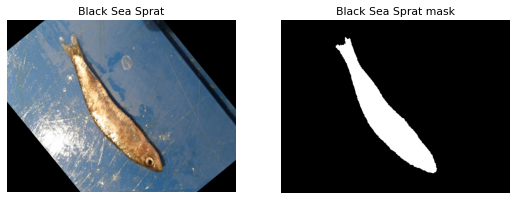

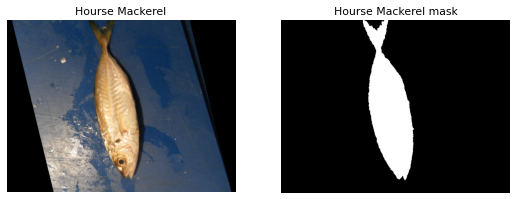

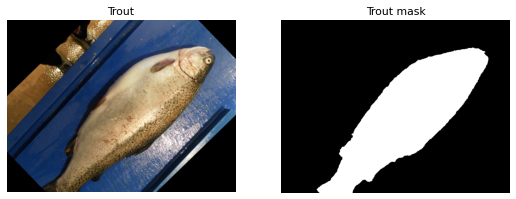

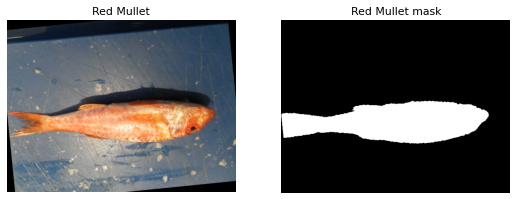

In [ ]:
sample_x, sample_y = fish_train_ds.sample_images()

for img_x, img_y in zip(sample_x, sample_y):
  image = Image.open(img_x)
  mask = Image.open(img_y)
  label = os.path.split(os.path.split(img_x)[0])[1]

  fig = plt.figure(figsize=(10,10), dpi=65)
  fig.add_subplot(1,2,1)
  plt.axis('off')
  plt.title(label)
  plt.imshow(image)

  fig.add_subplot(1,2,2)
  plt.axis('off')
  plt.title(label+" mask")
  plt.imshow(mask)
  plt.show()


## Creating a UNET

In [ ]:
Unet = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                     nn.ReLU(inplace=True),
                     nn.Conv2d(64,64, kernel_size=3, stride=2, padding=1),
                     nn.LeakyReLU(inplace=True),
                     nn.Conv2d(64,128, kernel_size=5, stride=1, padding=1),
                     nn.LeakyReLU(inplace=True),
                     nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
                     nn.LeakyReLU(inplace=True),
                     nn.ConvTranspose2d(128,64, kernel_size=4, stride=2),
                     nn.LeakyReLU(inplace=True),
                     nn.ConvTranspose2d(64, 1, kernel_size=6, stride=2),
                     )

Unet.to(device=DEVICE)
summary(Unet, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
              ReLU-2         [-1, 64, 112, 112]               0
            Conv2d-3           [-1, 64, 56, 56]          36,928
         LeakyReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 54, 54]         204,928
         LeakyReLU-6          [-1, 128, 54, 54]               0
            Conv2d-7          [-1, 128, 54, 54]         147,584
         LeakyReLU-8          [-1, 128, 54, 54]               0
   ConvTranspose2d-9         [-1, 64, 110, 110]         131,136
        LeakyReLU-10         [-1, 64, 110, 110]               0
  ConvTranspose2d-11          [-1, 1, 224, 224]           2,305
Total params: 524,673
Trainable params: 524,673
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/

### Initial Unet Output

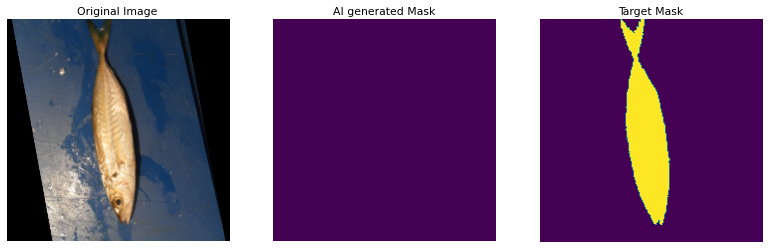

In [ ]:
Unet.eval()
with torch.no_grad():
  for x, y in miniloader:
    x = x.to(device=DEVICE)
    output = Unet(x)

    test_ai(x, output, y)




## Training the UNET

In [ ]:
optimizer = optim.Adam(Unet.parameters(), lr=LEARNING_RATE)
Unet.train()

avg_loss = 0
avg_accuracy = 0

for epoch in range(EPOCHS):
  loop = tqdm(train_dl)
  epoch_accuracy = 0
  epoch_loss = 0
  batch_length = len(loop)
  for batch_idx, (images, masks) in enumerate(loop):
    optimizer.zero_grad()

    images = images.to(device=DEVICE)
    masks = masks.to(device=DEVICE)

    output = Unet(images)
    loss = LOSS_FUNCTION(output, masks)

    loss.backward()
    optimizer.step()
    
    accuracy = iou(outputs=output, targets=masks)
    epoch_accuracy = epoch_accuracy + accuracy
    epoch_loss = epoch_loss + loss.item()
    loop.set_postfix(loss=epoch_loss/(batch_idx+1), accuracy=epoch_accuracy*100/(batch_idx+1), batch_no=batch_idx+1)

  avg_loss = avg_loss + epoch_loss/batch_length
  avg_accuracy = avg_accuracy + epoch_accuracy/batch_length

print("\nAverage trainging loss is {} \nAverage training accuracy is {}%".format((avg_loss/EPOCHS), (avg_accuracy*100/EPOCHS)))








100%|██████████| 254/254 [01:35<00:00,  2.66it/s, accuracy=87, batch_no=254, loss=0.061]


Average trainging loss is 0.09593162012440482 
Average training accuracy is 80.84882103397648%


## Checking Trained AI Output

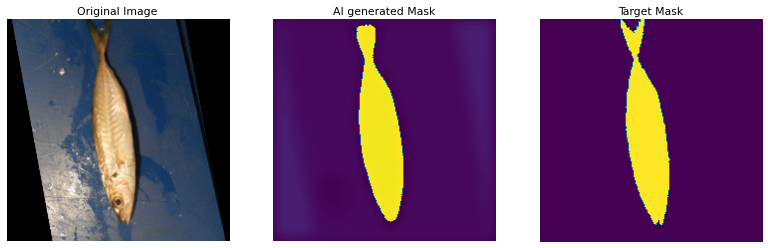

In [ ]:
Unet.eval()
with torch.no_grad():
  for x, y in miniloader:
    x = x.to(device=DEVICE)
    output = Unet(x)

    test_ai(x, output, y)


    

## Testing UNET with testing dataset

In [ ]:
avg_accuracy = 0
batch_length = 1

Unet.eval()
with torch.no_grad():
  loop = tqdm(test_dl)
  batch_length = len(loop)

  for batch_idx, (images, masks) in enumerate(loop):
    images = images.to(device=DEVICE)
    masks = masks.to(device=DEVICE)

    outputs = Unet(images)

    accuracy = iou(outputs=outputs, targets=masks)
    avg_accuracy = avg_accuracy + accuracy

    loop.set_postfix(accuracy=avg_accuracy*100/(batch_idx+1), batch_no=batch_idx+1)

  avg_accuracy = (avg_accuracy/batch_length)*100
print("\nAverage testing accuracy of the Unet is {}%".format(avg_accuracy))



100%|██████████| 29/29 [00:09<00:00,  3.00it/s, accuracy=86.7, batch_no=29]


Average testing accuracy of the Unet is 86.68671784729793%


## Saving the model



In [ ]:
torch.save(Unet, '/content/fish_unet')